In [1]:
import sys
import os
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import cv2
from skimage.io import imread

from gen.load_data import load_data
from gen.generators import preprocess_label
from keras.models import Model, load_model


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_df, valid_df, test_df = load_data('../data')
test_df.head()

image                   id  \
0  ../data/Test/CameraRGB/episode_0008_000112.png  episode_0008_000112   
1                ../data/Test/CameraRGB/00019.png                00019   
2  ../data/Test/CameraRGB/episode_0012_000130.png  episode_0012_000130   
3  ../data/Test/CameraRGB/episode_0010_000160.png  episode_0010_000160   
4                ../data/Test/CameraRGB/00413.png                00413   

                                            label  
0  ../data/Test/CameraSeg/episode_0008_000112.png  
1                ../data/Test/CameraSeg/00019.png  
2  ../data/Test/CameraSeg/episode_0012_000130.png  
3  ../data/Test/CameraSeg/episode_0010_000160.png  
4                ../data/Test/CameraSeg/00413.png

In [4]:
from models.unet import model_unetVGG16
from models.segnet import model_segnetVGG16
import keras.backend as K
# model = model_unetVGG16(nClasses=3, image_shape=(320, 416, 3))
# model.load_weights('../saved_models/unet/unet_v4/model.hdf5')
# model = load_model('../saved_models/unet/unet_v4/model_saved.h5')
# model = load_model('../saved_models/segnet/segnet_v2//model_saved.h5')

# model = model_segnetVGG16(3, image_shape=(320, 416, 3))
# model.load_weights('../saved_models/segnet/segnet_v2//model.hdf5')

K.set_learning_phase(0)
# model = load_model('../saved_models/fcn8/fcn8_v9//model_saved.h5')
model = load_model('../saved_models/segnet/segnet_v4/model_saved.h5')

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


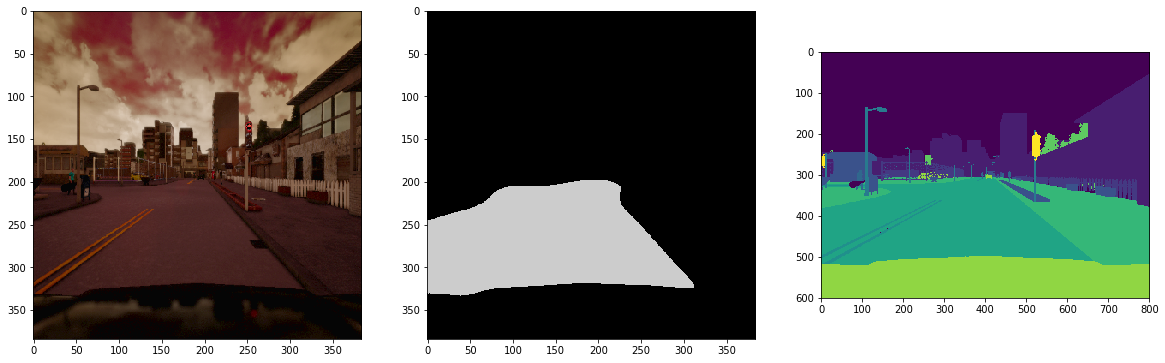

In [51]:

s = test_df.loc[np.random.randint(0, test_df.shape[0])]
img = imread(s[0])
img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
random_bright = .25+np.random.uniform()
img[:,:,2] += 5

img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)

    
img = cv2.resize(img, (384, 384))
p = model.predict(np.expand_dims(img, 0))
p_img = p[0].argmax(axis=-1)
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
output = np.zeros((p_img.shape[0], p_img.shape[1]))
output[p_img == 0] = 1
output[p_img == 1] = 2
plt.imshow(output, cmap='nipy_spectral')
plt.subplot(133)
plt.imshow(imread(s[2])[:, :, 0])

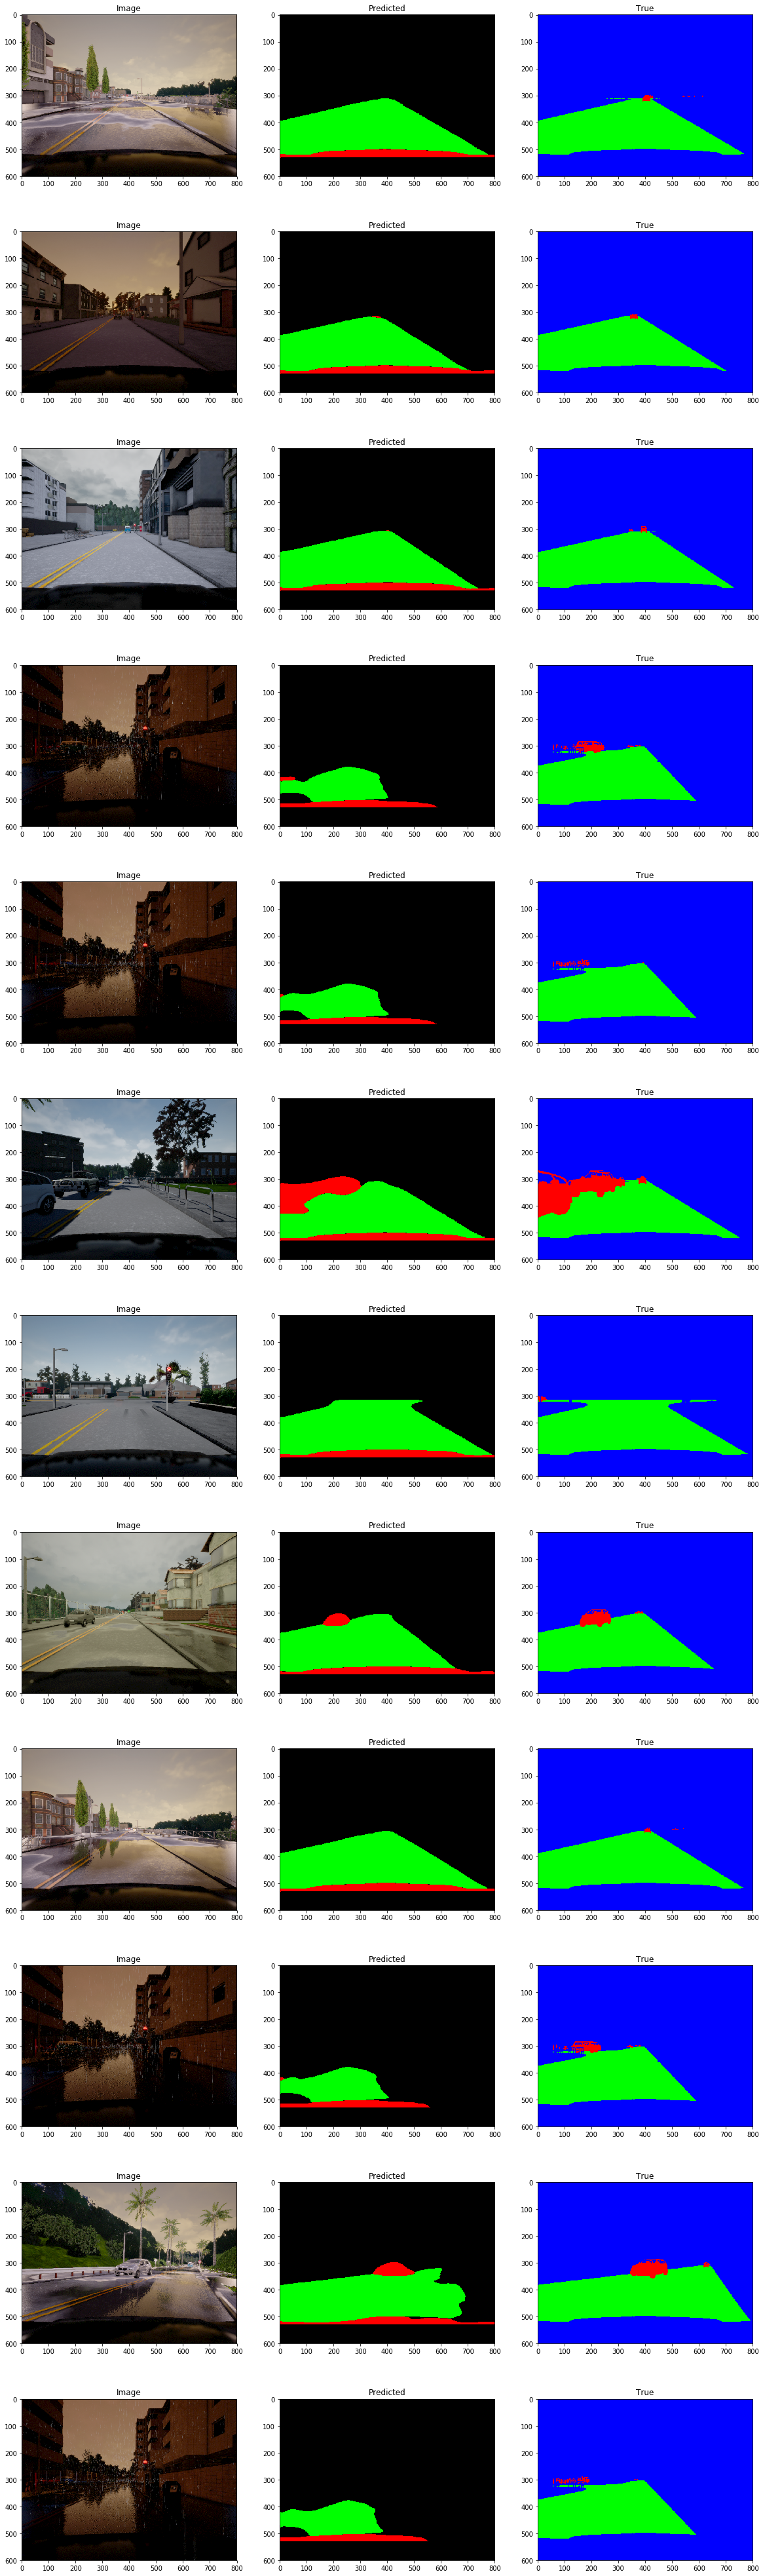

In [9]:
# from keras.applications.vgg16 import preprocess_input

sample_rows = 12
binary_car_result = np.zeros((600, 800))
binary_road_result = np.zeros((600, 800))
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, test_df.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image'])[200:, :, :]
    r_rgb_img = imread(c_row['image'])
    c_img = c_img
    p_img = model.predict(np.expand_dims(cv2.resize(c_img, (384, 384)), 0))[0]
    p_img = (p_img.reshape((384, 384, -1))).argmax(axis=-1)

        
    binary_car_result[200:, :] = cv2.resize((p_img == 0).astype(np.uint8), (800, 400))
    binary_road_result[200:, :] = cv2.resize((p_img == 1).astype(np.uint8), (800, 400))
    
    output_lbl = np.zeros((600, 800, 3))
    output_lbl[:, :, 0] = binary_car_result #cv2.resize(binary_car_result, (800, 600))
    output_lbl[:, : , 1] = binary_road_result #cv2.resize(binary_road_result, (800, 600))
    
    l_img = imread(c_row['label'])
    l_img = preprocess_label(l_img)
    
    ax1.imshow(r_rgb_img)
    ax1.set_title('Image')    
    ax2.imshow(output_lbl)
    ax2.set_title('Predicted')
    ax3.imshow(l_img*255)
    ax3.set_title('True')

In [10]:
def scoreIt(model, image, truth_data_car, truth_data_road):
    result = model.predict(np.expand_dims(image, 0))
    
    output = result[0].argmax(axis=2)
    student_data_car = np.zeros((600, 800))
    student_data_road = np.zeros((600, 800))
    student_data_car[200:, :] = cv2.resize((output == 0).astype(np.uint8), (800, 400))
    student_data_road[200:, :] = cv2.resize((output == 1).astype(np.uint8), (800, 400))
#     student_data_car = cv2.resize((result[0, :, :, 0] > 0.95 ).astype(np.uint8), (800, 600))
#     student_data_road = cv2.resize((result[0, :, :, 1] > 0.7).astype(np.uint8), (800, 600))
        
    Car_TP = 0 # True Positives
    Car_FP = 0 # Flase Positives
    Car_TN = 0 # True Negatives
    Car_FN = 0 # True Negatives

    Road_TP = 0 # True Positives
    Road_FP = 0 # Flase Positives
    Road_TN = 0 # True Negatives
    Road_FN = 0 # True Negatives

    Car_TP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 1)) + np.e
    Car_FP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 0)) + np.e
    Car_TN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 0)) + np.e
    Car_FN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 1)) + np.e
    
    Road_TP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 1)) + np.e
    Road_FP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 0)) + np.e
    Road_TN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 0))+  np.e
    Road_FN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 1))+  np.e
    
    Car_precision = Car_TP/(Car_TP+Car_FP)/1.0
    Car_recall = Car_TP/(Car_TP+Car_FN)/1.0
    Car_beta = 2.0
    Car_F = (1+Car_beta**2) * ((Car_precision*Car_recall)/(Car_beta**2.0 * Car_precision + Car_recall))
    Road_precision = Road_TP/(Road_TP+Road_FP)/1.0
    Road_recall = Road_TP/(Road_TP+Road_FN)/1.0
    Road_beta = 0.5
    Road_F = (1+Road_beta**2.0) * ((Road_precision*Road_recall)/(Road_beta**2.0 * Road_precision + Road_recall))
    
    return result, student_data_car, student_data_road,(Car_F + Road_F)/2.0

0.3155644432059078


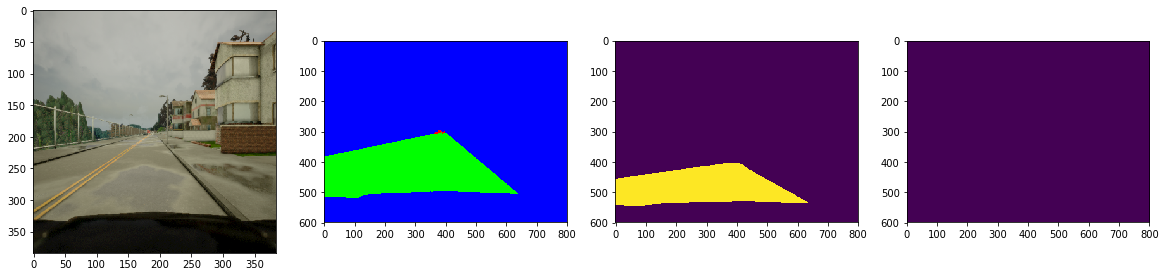

In [12]:
ind = np.random.randint(0, 30)
img = cv2.resize(imread(test_df.loc[ind].image), (384, 384))
lbl = preprocess_label(imread(test_df.loc[ind].label))

res, car, road, score = scoreIt(model, img, lbl[:, :, 0], lbl[:, :, 1])

print (score)
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(img)
plt.subplot(142)
plt.imshow(lbl*255)
plt.subplot(143)
plt.imshow(road*255)
plt.subplot(144)
plt.imshow(car*255)

In [13]:
inds = []
scores = []
outputs = []

i = 0
for _, row in test_df.iterrows():
    img = cv2.resize(imread(row.image), (384, 384))
    lbl = preprocess_label(imread(row.label))
    res, car, road, score = scoreIt(model, img, lbl[:, :, 0], lbl[:, :, 1])
    scores.append(score)
    inds.append(i)
    outputs.append((res, img, lbl, car, road))
    i += 1

In [14]:
c = sorted(zip(scores, inds))

0.00810903549651305 180
0.00989690119413085 1518
0.010319003310351273 1596
0.013384144973092506 1471
0.018488964110218484 267
0.02001776730628809 737
0.029024916647609686 987
0.03070848137095942 97
0.0329158223255191 1058
0.034132373227147225 905
0.041217837918773974 498
0.04615262448096889 1602
0.04843556600344159 693
0.05481162492243537 282
0.057275929499455334 1390
0.060219820804946075 29
0.06188802241719027 1435
0.07521434598766323 1522
0.08845876788006676 192
0.09141349361402458 550


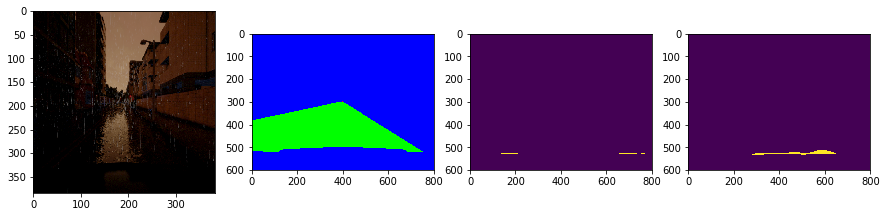

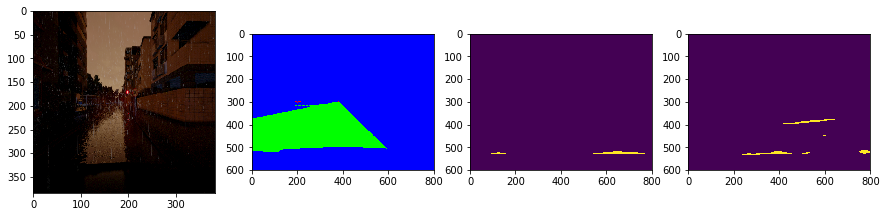

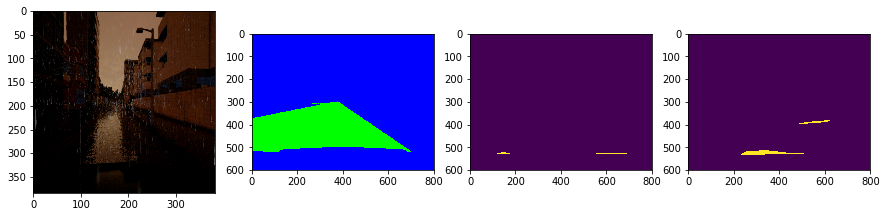

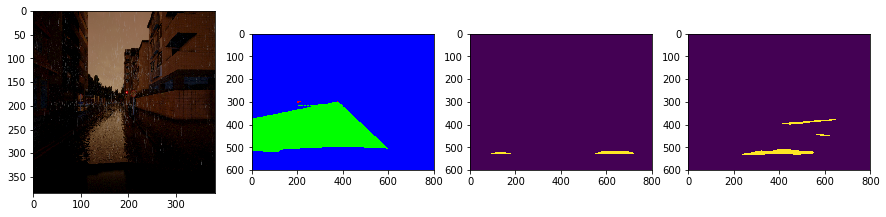

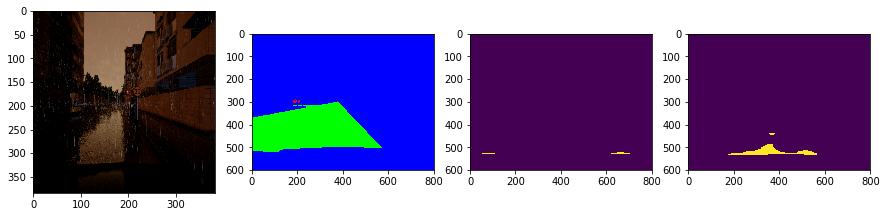

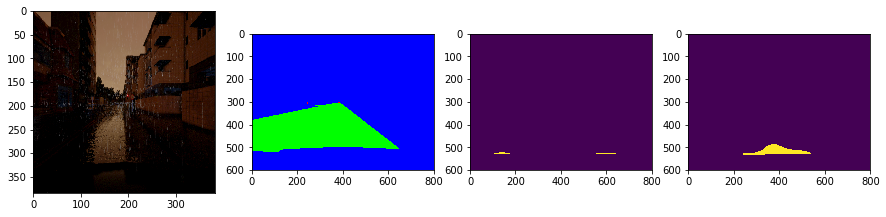

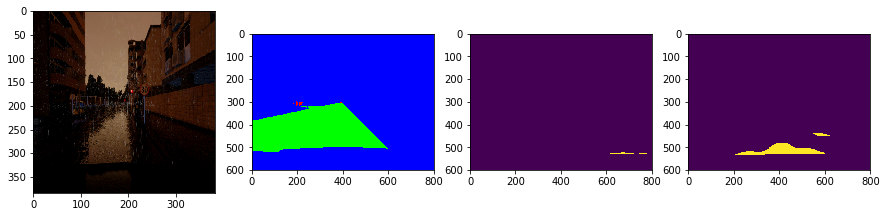

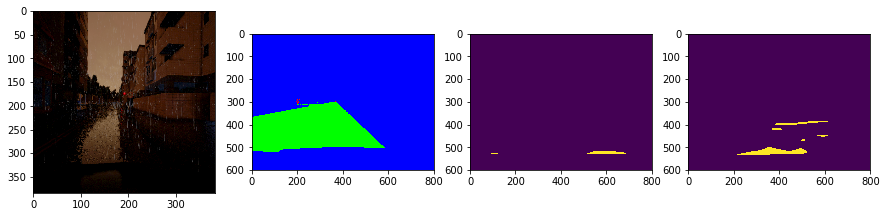

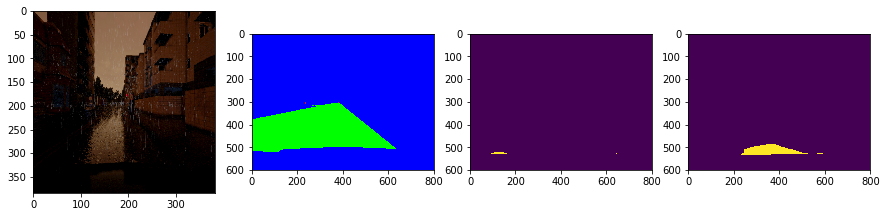

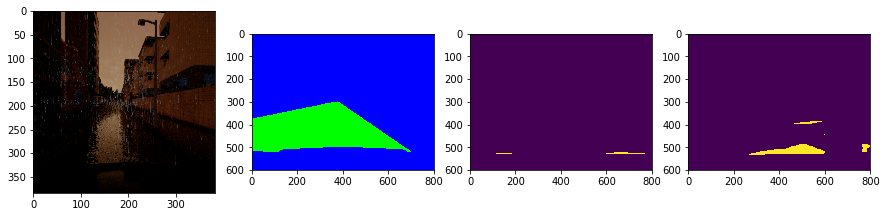

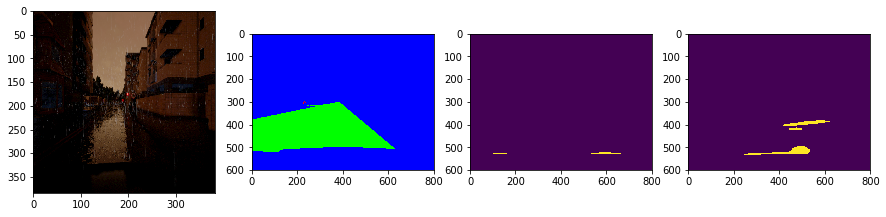

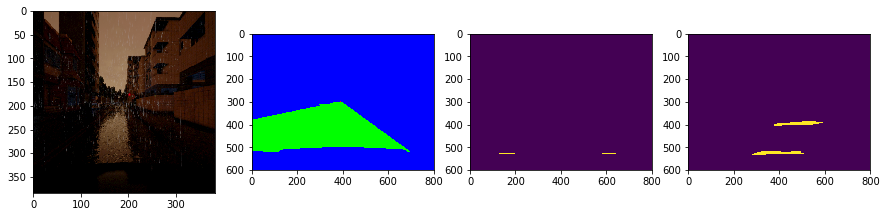

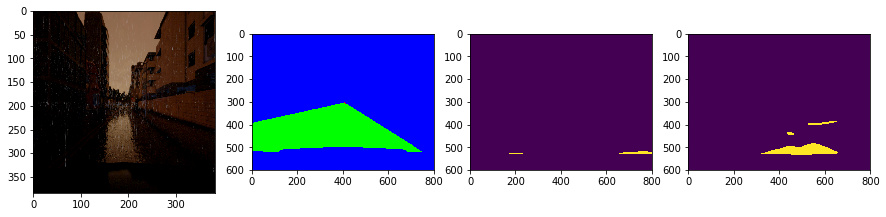

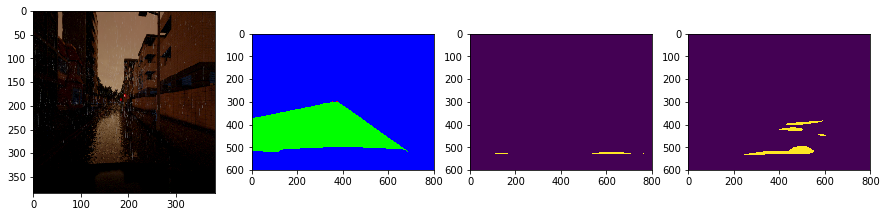

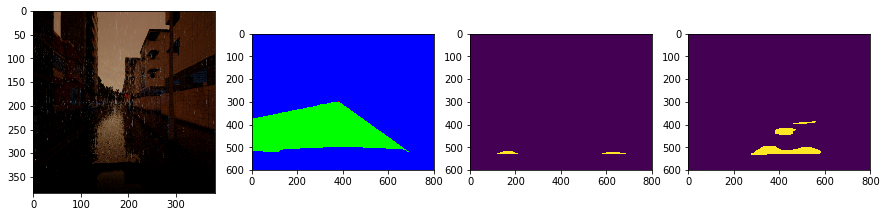

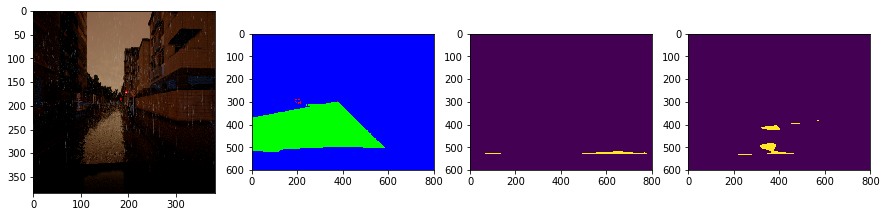

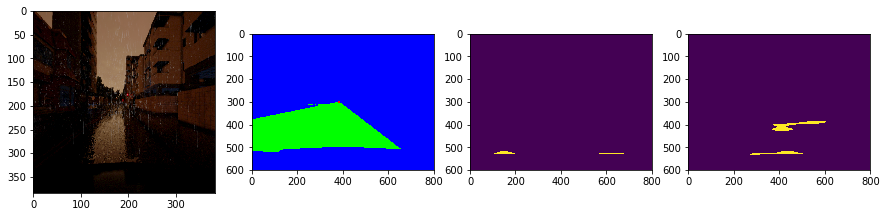

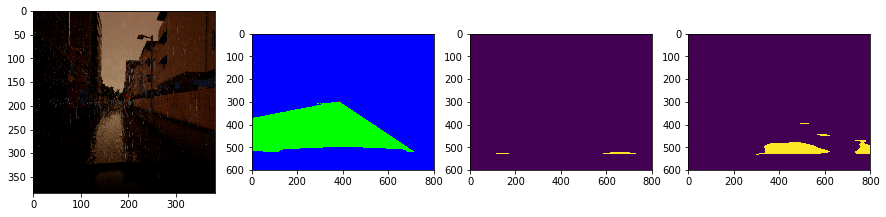

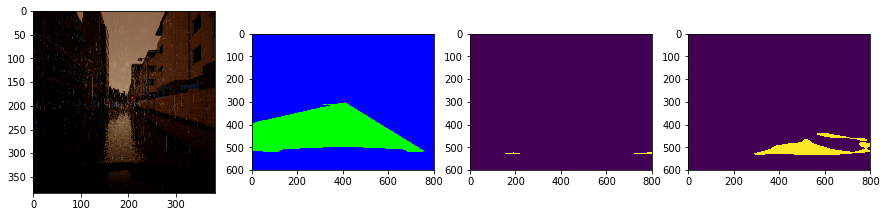

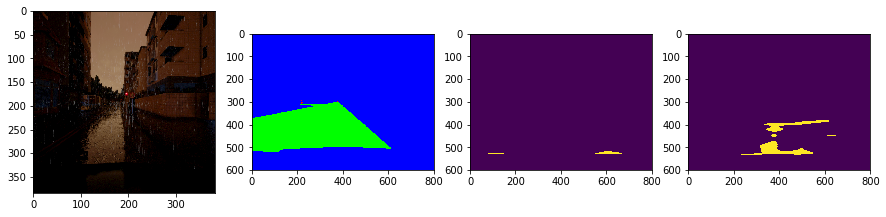

In [15]:
sample = c[0:20]
for s, i in sample:
    print (s, i)
    plt.figure(figsize=(15, 6*len(sample)))
    plt.subplot(141)
    plt.imshow(outputs[i][1])
    plt.subplot(142)
    plt.imshow(outputs[i][2]*255)
    plt.subplot(143)
    plt.imshow(outputs[i][3])
    plt.subplot(144)
    plt.imshow(outputs[i][4])

In [16]:
print (test_df.loc[217].image)

../data/Test/CameraRGB/00048.png


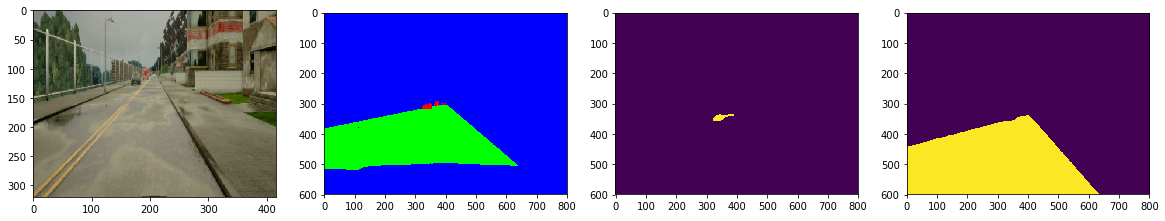

In [14]:
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(outputs[217][1])
plt.subplot(142)
plt.imshow(outputs[217][2]*255)
plt.subplot(143)
plt.imshow(outputs[217][3]*255)
plt.subplot(144)
plt.imshow(outputs[217][4]*255)

In [ ]:
probs = outputs[407][0][0]
print (probs[0, 0, 0], probs[0, 0, 1], probs[0, 0, 2])

In [ ]:
plt.imshow(probs[:, :, 0] > 0.9)

In [ ]:
plt.imshow(probs[:, :, 1])